In [1]:
try:
    import tensorflow_datasets, tensorflow, matplotlib, numpy, PIL, sklearn
except Exception as e:
    !pip install tensorflow_datasets tensorflow matplotlib numpy pillow scikit-learn

/Users/soumensardar/miniconda3/envs/tf/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset Selection

In [2]:
# DO NOT TOUCH BELOW ==================================
SMALL_DATASET = 0
FULL_DATASET = 1
FLOWER_DATASET = 2
# DO NOT TOUCH - END ===================================

# select dataset
SELECTED_DATASET = FLOWER_DATASET # CHANGE HERE


# DO NOT TOUCH BELOW ==================================
SMALL_DATASET_PATH = r'./smalldataset'
FULL_DATASET_PATH = r'C:\Users\HP\Downloads\PhdNotebook\OASIS dataset\OASIS dataset/Data'
FLOWER_DATASET_PATH = r"/Users/soumensardar/Downloads/flower_photos"
# while adding more datasets, make sure to add tflog directory
datasetdir, dataset_name =[(SMALL_DATASET_PATH,'tflogs_smalldataset'), 
                     (FULL_DATASET_PATH, 'tflogs'),
                     (FLOWER_DATASET_PATH, 'tflogs_flower_dataset'),
                    ][SELECTED_DATASET]
# DO NOT TOUCH - END ===================================
datasetdir, dataset_name

('/Users/soumensardar/Downloads/flower_photos', 'tflogs_flower_dataset')

# Test Image selection

In [3]:
TEST_IMG_PATH, TEST_IMG_LABEL = [
(r'C:\Users\HP\Downloads\PhdNotebook\OASIS dataset\OASIS dataset/Data/Non Demented/OAS1_0001_MR1_mpr-1_115.jpg', 'non_demented'),
(r'/Users/soumensardar/Downloads/gagan/smalldataset/Non Demented/OAS1_0001_MR1_mpr-1_105.jpg', 'non_demented'),
(r'/Users/soumensardar/Downloads/flower_photos/dandelion/151861297_55b10a03a6_n.jpg', 'dandelion'),
][SELECTED_DATASET]
TEST_IMG_PATH, TEST_IMG_LABEL

('/Users/soumensardar/Downloads/flower_photos/dandelion/151861297_55b10a03a6_n.jpg',
 'dandelion')

In [4]:
import os, json
def get_experiment_details(dataset, model, ts):
    exp_asset_dir = f"results/{dataset}/{model}/{ts}"
    assert os.path.exists(exp_asset_dir), f"Experiment does not exist '{exp_asset_dir}'"
    checkpoint_model_dir = None
    with open(exp_asset_dir + "/currentepoch.txt") as fp:
        last_epoch = int(fp.read().strip())
        checkpoint_model_dir = exp_asset_dir + "/models/epoch=%02d.h5"%last_epoch
        assert os.path.exists(checkpoint_model_dir), f"Unable to find the last checkpoint file {checkpoint_model_dir}"
    best_model_dir = exp_asset_dir + "/models/best-model.h5"
    if not os.path.exists(best_model_dir):
        best_model_dir = None

    best_model_info = None
    if os.path.exists(exp_asset_dir + "/bestvalue.json"):
        with open(exp_asset_dir + "/bestvalue.json") as fp:
            best_model_info = json.load(fp)
        
    return dict(last_epoch=last_epoch, 
                best_checkpoint=best_model_dir, 
                last_checkpoint=checkpoint_model_dir,
                best_model_info=best_model_info,
                project_dir=exp_asset_dir)

# <font color='red'>Hyperparameters

In [5]:
random_seed=37
resume_training_timestamp = None # CHANGE HERE
max_epoch = 30 # CHANGE HERE
batch_size = 64 # CHANGE HERE
image_size = 128
color_mode = 'rgb'
n_ch = dict(rgb=3, grayscale=1)[color_mode]
monitor = "f1_score"
initial_threshold = 0.5
mode="max"
freq="epoch"
initial_epoch=0
learning_rate = 0.001
enable_class_weight = True

import tensorflow as tf
# EACH LINK CONTAINS AVAILABLE OPTIONS
# Link: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers#classes
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) # CHANGE HERE
# Link: https://www.tensorflow.org/api_docs/python/tf/keras/metrics#classes
metrics = [tf.keras.metrics.Accuracy(), 
           tf.keras.metrics.Recall(), 
           tf.keras.metrics.Precision(),
           tf.keras.metrics.F1Score(average="macro"),
           tf.keras.metrics.SensitivityAtSpecificity(0.6),
           tf.keras.metrics.SpecificityAtSensitivity(0.6),
          ] # CHANGE HERE
# Link: https://www.tensorflow.org/api_docs/python/tf/keras/losses#functions
loss_function = "categorical_crossentropy" # CHANGE HERE
# Link: https://keras.io/api/applications/
model_name="MobileNet" # CHANGE HERE
# add a comment about what changes you have done just now before running the training
what_changed = f"Training with {model_name}"

2024-12-12 20:41:54.443028: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-12-12 20:41:54.443050: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-12-12 20:41:54.443058: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-12-12 20:41:54.443318: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-12 20:41:54.443699: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
resume_checkpoint_path = None
if resume_training_timestamp:
    print(f"Trying to resume from checkpoint... {resume_training_timestamp}")
    d = get_experiment_details(dataset_name, model_name, resume_training_timestamp)
    initial_epoch = d['last_epoch']
    resume_checkpoint_path = d['last_checkpoint']
    assert os.path.exists(resume_checkpoint_path), f"Unable to resume training from '{d['project_dir']}'."
    best_model_info = d['best_model_info']
    if best_model_info:
        print("Updating the metric monitoring parameters before resuming the checkpoint")
        monitor = best_model_info['monitor']
        initial_threshold = best_model_info['value']
        mode=best_model_info['mode']
        freq=best_model_info['frequency']
    print(f"Resuming checkpoint form epoch={initial_epoch}.")
# =====================================================


def save_hparams():
    hyprams = dict(
            timestamp = timestamp,
            what_changed=what_changed,
            random_state=random_seed,
            max_epoch=max_epoch,
            batch_size=batch_size,
            image_size=image_size,
            num_channels=n_ch,
            metrics=str(metrics),
            loss_function=loss_function,
            monitoring=dict(monitor = monitor, initial_threshold = initial_threshold, mode=mode),
            resume_training_timestamp=resume_training_timestamp,
            initial_epoch=initial_epoch,
            model_name=model_name,
            optimizer=optimizer.name,
            learning_rate=learning_rate,
        )
    import json 
    log("Saving hyperparameters.")
    print(hyprams)
    # Convert and write JSON object to file
    with open(f"{artifact_root}/hyperparams.json", "w") as outfile: 
        json.dump(hyprams, outfile, indent=4)
    file_writer = tf.summary.create_file_writer(tf_log_dir + "/hparams")
    with file_writer.as_default():
        tf.summary.text("hyperparams.json", f"{artifact_root}/hyperparams.json", step=0)
        for k, v in hyprams.items():
            if isinstance(v, int):
                tf.summary.scalar(k, v, step=0)
            elif isinstance(v, float):
                tf.summary.scalar(k, v, step=0)
            else:
                tf.summary.text(k, str(v), step=0)

# Prepare artifact directory

In [7]:
import pathlib
import datetime

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
if resume_training_timestamp:
    print("Resume timestamp", resume_training_timestamp)
    timestamp = resume_training_timestamp
unique_dir = f"{model_name}/{timestamp}"
tf_log_dir = f"results/{dataset_name}/{unique_dir}"
tf_log_img_dir = f"results/{dataset_name}/images"
artifact_root  = f"results/{dataset_name}/{unique_dir}"
pathlib.Path(artifact_root).mkdir(parents=True, exist_ok=True)
pathlib.Path(tf_log_dir).mkdir(parents=True, exist_ok=True)

def log(*args, **kwargs):
    time = False
    if "time" in kwargs.keys():
        time = kwargs["time"]
        del kwargs["time"]
    if time:
        time = datetime.datetime.now().strftime("%H:%M:%S %d/%m/%Y")
        a = list(args)
        a.append(time)
        args = tuple(a)
    print(*args, **kwargs)
    with open(f"{artifact_root}/additional_logs.txt", "a") as fp:
        kwargs["file"] = fp
        kwargs["flush"] = True
        print(*args, **kwargs)
log(f"Experiment path: '{artifact_root}'")

Experiment path: 'results/tflogs_flower_dataset/MobileNet/20241212-204154'


# <font color='red'>Training Resume Timestamp
## Use this `timestamp` to update `resume_training_timestamp` variable

In [8]:
log(f"Resume timestamp: {timestamp}")

Resume timestamp: 20241212-204154


In [9]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
#   DataGenerator to read images and rescale images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import os
import random
tf.random.set_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

# Loading datasets

In [10]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import json

raw_train_val_ds, raw_test_ds = tf.keras.utils.image_dataset_from_directory(
  datasetdir,
  validation_split=0.20,
  subset='both',
  label_mode = "categorical",
  color_mode=color_mode,
  seed=random_seed,
  image_size=(image_size, image_size),
  batch_size=batch_size,
)

CLASS_NAMES = raw_train_val_ds.class_names
num_classes = len(CLASS_NAMES)


# Create a test dataset by further splitting the validation set
raw_val_batches = tf.data.experimental.cardinality(raw_train_val_ds)
print(raw_val_batches)
raw_val_ds = raw_train_val_ds.take(raw_val_batches // 5)  # 20% of validation as test
raw_train_ds = raw_train_val_ds.skip(raw_val_batches // 5)

# normalization
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = raw_train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = raw_val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = raw_test_ds.map(lambda x, y: (normalization_layer(x), y))

# Performance and caching
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Using 734 files for validation.
tf.Tensor(46, shape=(), dtype=int64)


Type:           _BatchDataset
String form:    <_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
Length:         46
File:           ~/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/data/ops/batch_op.py
Docstring:      A `Dataset` that batches contiguous elements from its input.
Init docstring: See `Dataset.batch()` for details.

# Class Weight

In [24]:
class_weights = {CLASS_NAMES.index(c):1.0 for c in CLASS_NAMES}

if enable_class_weight:
    from collections import Counter
    
    class SmartCounter(dict):
        def __add__(self, new_dict):
            for key, val in new_dict.items():
                curr = self.get(key, 0)
                self[key] = curr + val
            return self
    
        def total(self):
            return sum([v for k, v in self.items()])
                
            
    ctr = SmartCounter()
    for img, lbl in raw_train_val_ds:
        v = Counter(list(map(lambda x: CLASS_NAMES[x], np.argmax(lbl, axis=1))))
        ctr = ctr + v
    
    t = ctr.total()
    weights = {k: t/v for k, v in ctr.items()}
    
    ws = np.array(list(weights.values()))
    ks = np.array(list(weights.keys()))
    # normalize the weights
    ws = (ws - np.min(ws)) / (np.max(ws) - np.min(ws))
    norm_weights = {}
    # Make sure the order of the keys is intact,
    # thus preparing a new dictionary
    for k, w in zip(ks, ws):
        norm_weights[k] = w
    
    class_weights = {CLASS_NAMES.index(c):norm_weights[c] for c in CLASS_NAMES}

    "Main=========", ctr, "Weight=========", weights, "Norm-Weight=========", norm_weights

"Class Weight=========", class_weights

('Class Weight=========',
 {0: 1.0,
  1: 0.0,
  2: 0.8584651776684552,
  3: 0.6352581656546414,
  4: 0.19723364085534859})

# Sample images

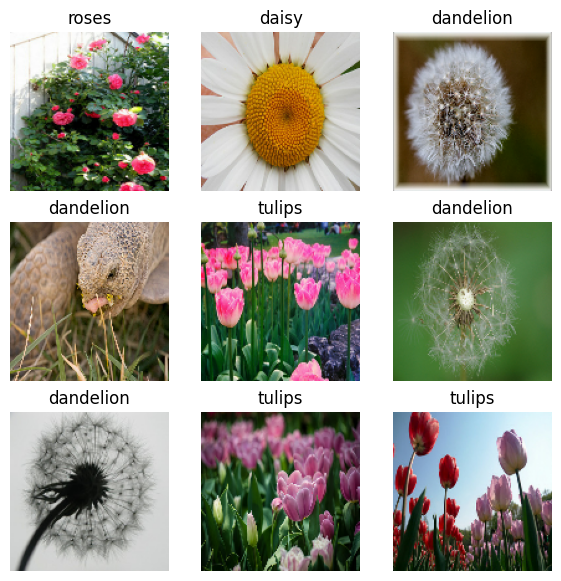

In [12]:
#print("Sample images")
plt.figure(figsize=(7,7))
for images, labels in raw_train_ds:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8")) #, cmap='Greys_r')
        plt.title(CLASS_NAMES[np.argmax(labels[i])])
        plt.axis("off")
    break
plt.show()

In [13]:
import math, io
def plot_to_image(figure):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  print("Preparing matplotlib to numpy")
  return image

def image_grid(ds, count=25):
    """Return a square grid of images as a tensor."""
    # Create a figure to contain the plot.
    n = int(math.sqrt(count))
    figure = plt.figure(figsize=(n*2,n*2))
    for images, labels in ds:
        for i in range(count):
            ax = plt.subplot(n, n, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(CLASS_NAMES[np.argmax(labels[i])])
            plt.axis("off")
        break
    return plot_to_image(figure)

def validation_image_grid(count=25):
    """Return a square grid of images as a tensor"""
    # Create a figure to contain the plot.
    print("Preparing sample grid for validation images")
    return image_grid(raw_val_ds, count)

def train_image_grid(count=25):
    """Return a square grid of images as a tensor."""
    # Create a figure to contain the plot.
    print("Preparing sample grid for training images")
    return image_grid(raw_train_ds, count)

def test_image_grid(count=25):
    """Return a square grid of images as a tensor."""
    # Create a figure to contain the plot.
    print("Preparing sample grid for testing images")
    return image_grid(raw_test_ds, count)
    

tf_exclusive_image_logger = tf.summary.create_file_writer(tf_log_img_dir)
with tf_exclusive_image_logger.as_default():
    tf.summary.image("Training Image Sample", train_image_grid(9), step=0)
    tf.summary.image("Validation Image Sample", validation_image_grid(4), step=0)
    tf.summary.image("Testing Image Sample", test_image_grid(4), step=0)

Preparing sample grid for training images
Preparing matplotlib to numpy
Preparing sample grid for validation images
Preparing matplotlib to numpy
Preparing sample grid for testing images
Preparing matplotlib to numpy


# Logger and Callbacks

In [14]:
# CSV Logger
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from tensorflow.keras.callbacks import LambdaCallback, Callback
import shutil, glob

# Create EarlyStopping callback
early_stopping = EarlyStopping(monitor="val_loss", 
                               mode="min", 
                               patience=7, 
                               min_delta=0.001,
                               verbose=1,
                               start_from_epoch=9,
                               restore_best_weights=True)

csv_logger = CSVLogger(artifact_root + '/metrics.csv')
# Tensorboard Logger
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=tf_log_dir,
    histogram_freq=0,
    write_graph=False,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None    
)

model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    artifact_root + "/models/epoch={epoch:02d}.h5",
    monitor=monitor,
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode=mode,
    save_freq=freq,
    initial_value_threshold=initial_threshold,
)

model_best_ckpt = tf.keras.callbacks.ModelCheckpoint(
    artifact_root + "/models/best-model.h5",
    monitor=monitor,
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode=mode,
    save_freq=freq,
    initial_value_threshold=initial_threshold,
)

class BestModelEpochTrackerCallback(Callback):
    """
    This callback monitor best values and updates in a json file project_dir/bestvalue.json
    """
    def __init__(self, monitor, mode, initial_value_threshold=None, verbose=0):
        assert mode in ("min", "max")
        initial_thresh = initial_value_threshold
        self.monitor = monitor
        self.mode = mode
        self.best_value = initial_thresh
        if mode == "min":
            self.is_better = np.less
            if self.best_value is None:
                self.best_value = np.Inf
        elif mode == "max":
            self.is_better = np.greater
            if self.best_value is None:
                self.best_value = -np.Inf 
        self.verbose = verbose
        
    def on_epoch_end(self, epoch, metrics=None):
        curr_val = metrics.get(self.monitor, None)
        assert curr_val is not None, f"Unable to find the metric to monitor: {self.monitor}"
        if self.is_better(curr_val, self.best_value):
            update_path = artifact_root + "/bestvalue.json"
            if self.verbose:
                print(f"Epoch {epoch+1}: {self.monitor} improved form {self.best_value:.5f} to {curr_val:.5f} and saving updates to {update_path}")
            self.best_value = curr_val
            with open(update_path, "w") as fp:
                json.dump(dict(epoch=epoch+1, 
                               monitor=self.monitor, 
                               value=curr_val, 
                               mode=self.mode, 
                               frequency="epoch"
                              ), fp, indent=4)
        else:
            if self.verbose:
                self.print(f"Epoch {epoch+1}: {self.monitor} did not improved form {self.best_value}")
            
                

bestval_monitor_callback = BestModelEpochTrackerCallback(
    monitor=monitor,
    mode=mode,
    initial_value_threshold=initial_threshold,
)



class CleanupCallback(Callback):
    def on_epoch_begin(self, epoch, metrics=None):
        # clean last checkpoint assets
        last_epoch = epoch - 1
        # update current
        with open(artifact_root + "/currentepoch.txt", "w") as fp:
            fp.write(f"{epoch}")
        # look for last epoch checkpoint and delete
        pattern = artifact_root + "/models/epoch=%02d.h5" % (last_epoch)
        if os.path.exists(pattern):
            os.remove(pattern)
        
        
cleanup_callback = CleanupCallback()

callbacks = [csv_logger, tensorboard_callback, model_ckpt, model_best_ckpt, bestval_monitor_callback, cleanup_callback,]



# Model build

In [15]:
# Define the model architecture (ResNet50)
# import tensorflow.keras as K
log("Building model...")
import keras as K

input_t= K.Input(shape=(image_size,image_size,n_ch))
res_model= getattr(K.applications, model_name)(include_top=False, weights="imagenet", input_tensor=input_t)
model_lenet = K.models.Sequential()
model_lenet.add(res_model)
model_lenet.add(K.layers.Flatten())
model_lenet.add(K.layers.Dense(num_classes, activation='softmax'))


Building model...


# Training

In [16]:
# reload checkpoint
if resume_checkpoint_path and os.path.exists(resume_checkpoint_path):
    log("Resuming training...", resume_checkpoint_path)
    model_lenet.load_weights(resume_checkpoint_path)
else:
    log("Fresh training...")
    initial_epoch = 0
# daving hyper-params
save_hparams()

# Compile the model
log("Compile model")
model_lenet.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

# Train the model
log("Experiment: Started", time=True)
log(f"Starting training model={model_name}")
history = model_lenet.fit(train_ds, epochs=max_epoch, initial_epoch=initial_epoch, batch_size=batch_size, 
                          callbacks = callbacks,
                          class_weight=class_weights,
                          validation_data=val_ds)
log(f"Training done={model_name}")

Fresh training...
Saving hyperparameters.
{'timestamp': '20241212-204154', 'what_changed': 'Training with MobileNet', 'random_state': 37, 'max_epoch': 30, 'batch_size': 64, 'image_size': 128, 'num_channels': 3, 'metrics': '[<keras.src.metrics.accuracy_metrics.Accuracy object at 0x30b771520>, <keras.src.metrics.confusion_metrics.Recall object at 0x30b7e3850>, <keras.src.metrics.confusion_metrics.Precision object at 0x30b7e3e80>, <keras.src.metrics.f_score_metrics.F1Score object at 0x310f79a60>, <keras.src.metrics.confusion_metrics.SensitivityAtSpecificity object at 0x310f7e580>, <keras.src.metrics.confusion_metrics.SpecificityAtSensitivity object at 0x310f98610>]', 'loss_function': 'categorical_crossentropy', 'monitoring': {'monitor': 'f1_score', 'initial_threshold': 0.5, 'mode': 'max'}, 'resume_training_timestamp': None, 'initial_epoch': 0, 'model_name': 'MobileNet', 'optimizer': 'Adam', 'learning_rate': 0.001}
Compile model
Experiment: Started 20:41:58 12/12/2024
Starting training mod

2024-12-12 20:41:59.950136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - ETA: 0s - loss: 0.8019 - accuracy: 0.0737 - recall: 0.5254 - precision: 0.5310 - f1_score: 0.4870 - sensitivity_at_specificity: 0.6479 - specificity_at_sensitivity: 0.8173

2024-12-12 20:42:08.513205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: f1_score did not improve from 0.50000
37/37 [==============================] - 11s 233ms/step - loss: 0.8019 - accuracy: 0.0737 - recall: 0.5254 - precision: 0.5310 - f1_score: 0.4870 - sensitivity_at_specificity: 0.6479 - specificity_at_sensitivity: 0.8173 - val_loss: 65.4618 - val_accuracy: 0.2146 - val_recall: 0.3125 - val_precision: 0.3125 - val_f1_score: 0.2468 - val_sensitivity_at_specificity: 0.3559 - val_specificity_at_sensitivity: 0.2075
Epoch 2/30


/Users/soumensardar/miniconda3/envs/tf/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 [==============================] - ETA: 0s - loss: 0.2892 - accuracy: 0.1202 - recall: 0.6403 - precision: 0.6479 - f1_score: 0.5872 - sensitivity_at_specificity: 0.7242 - specificity_at_sensitivity: 0.9321
Epoch 2: f1_score improved from 0.50000 to 0.58715, saving model to results/tflogs_flower_dataset/MobileNet/20241212-204154/models/best-model.h5
37/37 [==============================] - 7s 193ms/step - loss: 0.2892 - accuracy: 0.1202 - recall: 0.6403 - precision: 0.6479 - f1_score: 0.5872 - sensitivity_at_specificity: 0.7242 - specificity_at_sensitivity: 0.9321 - val_loss: 48.6877 - val_accuracy: 0.2323 - val_recall: 0.5278 - val_precision: 0.5305 - val_f1_score: 0.4805 - val_sensitivity_at_specificity: 0.5990 - val_specificity_at_sensitivity: 0.2066
Epoch 3/30
37/37 [==============================] - ETA: 0s - loss: 0.1578 - accuracy: 0.1280 - recall: 0.6852 - precision: 0.6925 - f1_score: 0.6297 - sensitivity_at_specificity: 0.7445 - specificity_at_sensitivity: 0.9454
Epoch 

In [17]:
# Evaluate the model on the test set
log("Experiment: Evaluating", time=True)
log(f"Evaluating model={model_name}...")
test_result = model_lenet.evaluate(test_ds)

Experiment: Evaluating 20:45:42 12/12/2024
Evaluating model=MobileNet...
12/12 [==============================] - 1s 82ms/step - loss: 35.5193 - accuracy: 0.1894 - recall: 0.6608 - precision: 0.6653 - f1_score: 0.6106 - sensitivity_at_specificity: 0.7234 - specificity_at_sensitivity: 0.9424


In [18]:
class LossMetric(tf.keras.metrics.Metric):
    def __init__(self, name='loss', **kwargs):
        super().__init__(name='loss', **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        pass

    def result(self):
        return 0

In [19]:
metrics.append(LossMetric())

log(f"{model_name}", {f"test_{k.name}":v for v,k in zip(test_result, metrics)})

# TF-logging test values
file_writer = tf.summary.create_file_writer(tf_log_dir + "/test")
with file_writer.as_default():
    for v, k in zip(test_result, metrics):
        tf.summary.scalar(f"test_{k.name}", v, step=0)

MobileNet {'test_accuracy': 35.51926040649414, 'test_recall': 0.18937329947948456, 'test_precision': 0.6607629656791687, 'test_f1_score': 0.6652949452400208, 'test_sensitivity_at_specificity': 0.6106297373771667, 'test_specificity_at_sensitivity': 0.723433256149292, 'test_loss': 0.9424387216567993}


In [20]:
from PIL import Image
def preprocess_image(image_path, target_size=(image_size, image_size)):
    # Open the image file
    img = Image.open(image_path)
    # Resize the image
    img = img.resize(target_size)
    # Convert the image to a NumPy array
    img_array = np.array(img)
    # Expand dimensions to match the shape expected by the model (if necessary)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


# Example usage:
actual_class = TEST_IMG_LABEL
image_path = TEST_IMG_PATH
image_array = preprocess_image(image_path)
log("Shape of preprocessed image array:", image_array.shape)

# Predict probabilities
log("Experiment: Testing", time=True)
prediction_probabilities = model_lenet.predict(image_array)

# Get the index of the highest probability
predicted_class_index = np.argmax(prediction_probabilities)

# Define your class labels
class_labels = CLASS_NAMES

# Map the index to the corresponding class label
predicted_class = class_labels[predicted_class_index]

# TF-logging test values
file_writer = tf.summary.create_file_writer(tf_log_dir + "/test")
with file_writer.as_default():
    tf.summary.text(f"Corner Case", f"Actual={actual_class} Predicted={predicted_class}", step=0)

log("Actual class:", actual_class)
log("Predicted class:", predicted_class)
log("Experiment: Completed", time=True)

with file_writer.as_default():
    # Don't forget to reshape.
    figure = plt.figure(figsize=(5,5))
    images = np.reshape(image_array, (image_size, image_size, n_ch))
    plt.imshow(images)
    plt.title(f"Actual={actual_class} vs Predicted={predicted_class}")
    # TODO add actual vs predicted label
    images = plot_to_image(figure)
    tf.summary.image(f"Test Image", images, max_outputs=1, step=0)

Shape of preprocessed image array: (1, 128, 128, 3)
Experiment: Testing 20:45:43 12/12/2024


2024-12-12 20:45:44.247349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 709ms/step
Actual class: dandelion
Predicted class: tulips
Experiment: Completed 20:45:44 12/12/2024
Preparing matplotlib to numpy


In [21]:
log(f"Your result is saved at: '{artifact_root}'")

Your result is saved at: 'results/tflogs_flower_dataset/MobileNet/20241212-204154'


In [22]:
# start tensorboard
# Load the TensorBoard notebook extension
%reload_ext tensorboard
if SELECTED_DATASET == SMALL_DATASET:
    %tensorboard --logdir "results/tflogs_smalldataset/" 
elif SELECTED_DATASET == FULL_DATASET:
    %tensorboard --logdir "results/tflog/"
elif SELECTED_DATASET == FLOWER_DATASET:
    %tensorboard --logdir "results/tflogs_flower_dataset/" --port 6000

In [23]:
models = ["ResNet50", "VGG16", "InceptionResnetV2", "Mobilenet"]
batch_size = [32, 64, 1024]
loss_func = [ "categorical_cross_entropy", ]
optimizer = ["adam", ]
learning_rate = 0.001

for mod in models:
    for loss_ in loss_func:
        for op in optimizer:
            for bs in batch_size:
                print(dict(model=mod, loss_func = loss_, optimizer=op, batch_sieze=bs, lr=learning_rate))

{'model': 'ResNet50', 'loss_func': 'categorical_cross_entropy', 'optimizer': 'adam', 'batch_sieze': 32, 'lr': 0.001}
{'model': 'ResNet50', 'loss_func': 'categorical_cross_entropy', 'optimizer': 'adam', 'batch_sieze': 64, 'lr': 0.001}
{'model': 'ResNet50', 'loss_func': 'categorical_cross_entropy', 'optimizer': 'adam', 'batch_sieze': 1024, 'lr': 0.001}
{'model': 'VGG16', 'loss_func': 'categorical_cross_entropy', 'optimizer': 'adam', 'batch_sieze': 32, 'lr': 0.001}
{'model': 'VGG16', 'loss_func': 'categorical_cross_entropy', 'optimizer': 'adam', 'batch_sieze': 64, 'lr': 0.001}
{'model': 'VGG16', 'loss_func': 'categorical_cross_entropy', 'optimizer': 'adam', 'batch_sieze': 1024, 'lr': 0.001}
{'model': 'InceptionResnetV2', 'loss_func': 'categorical_cross_entropy', 'optimizer': 'adam', 'batch_sieze': 32, 'lr': 0.001}
{'model': 'InceptionResnetV2', 'loss_func': 'categorical_cross_entropy', 'optimizer': 'adam', 'batch_sieze': 64, 'lr': 0.001}
{'model': 'InceptionResnetV2', 'loss_func': 'catego